In [1]:
import cv2
import os
import numpy as np
from scipy.spatial.transform import Rotation
from matplotlib import pyplot as plt
import json
import math
import face_alignment

In [2]:
lmPath = "/Volumes/EVAN_DISK/MASC/Motion_paint/example_videos/rolling_in_the_deep_1/raw_mediapipe_landmark.npy"
videoPath = "/Volumes/EVAN_DISK/MASC/Motion_paint/example_videos/rolling_in_the_deep_1.mp4"

# lmPath = "/Volumes/EVAN_DISK/MASC/Motion_paint/example_videos/Child_in_time_2/raw_mediapipe_landmark.npy"
# lmPath = "E:/Facial Feature Motion Clip/rollingInTheDeep/raw_mediapipe_landmark.npy"
# lmPath = "/Volumes/KINGSTON/csc2521/raw_mediapipe_landmark.npy"
# outputPath = "/Volumes/EVAN_DISK/emp/child_in_time_motion.json"
outputPath = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/motion.json"
rotation_output_path = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/Rot_motion.json"
# info from video
t_segment = [0, 169]
t_ref = 0
# info of target animation
start = 0
fps = 30
min_cutoff = 0.0001
beta = 1.5

In [3]:
with open("mediaPipeMapping.json", "r") as f:
    maping = json.load(f)

staticLandmarkIndices = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
keypointIndicies = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]+maping["brow"]["rightLower"]+maping["brow"]["rightUpper"]+maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]+maping["eye"]["right"]+maping["eye"]["left"]+maping["lips"]["inner"]+maping["lips"]["outer"]
data = np.load(lmPath)

In [4]:
cap = cv2.VideoCapture(videoPath)
t = 0
flow_data = []
video_shape = []

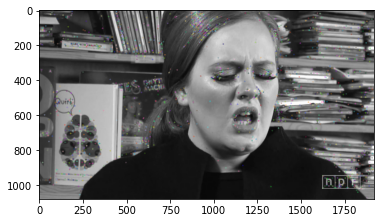

In [5]:
ret, frame_t1 = cap.read()
gray= cv2.cvtColor(frame_t1,cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)
img=cv2.drawKeypoints(gray,kp,frame_t1)
plt.imshow(img)

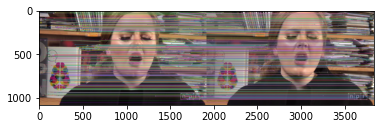

In [21]:
ret, frame_t0 = cap.read()
ret, frame_t1 = cap.read()
rtv = siftMatching(frame_t0, frame_t1)

In [22]:
print(rtv[0].shape,rtv[1].shape)

(1002, 2) (1002, 2)


In [23]:
import cv2
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, AffineTransform
import numpy as np


def siftMatching(img1, img2):
    # Input : image1 and image2 in opencv format
    # Output : corresponding keypoints for source and target images
    # Output Format : Numpy matrix of shape: [No. of Correspondences X 2] 

#     surf = cv2.xfeatures2d.SURF_create(100)
    surf = cv2.SIFT_create()

    kp1, des1 = surf.detectAndCompute(img1, None)
    kp2, des2 = surf.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # Lowe's Ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1, 2)

    # Ransac
    model, inliers = ransac(
            (src_pts, dst_pts),
            AffineTransform, min_samples=4,
            residual_threshold=8, max_trials=10
        )

    n_inliers = np.sum(inliers)

    inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in src_pts[inliers]]
    inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in dst_pts[inliers]]
    placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
    image3 = cv2.drawMatches(img1, inlier_keypoints_left, img2, inlier_keypoints_right, placeholder_matches, None)
    plt.imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))
#     cv2.waitKey(0)

    src_pts = np.float32([ inlier_keypoints_left[m.queryIdx].pt for m in placeholder_matches ]).reshape(-1, 2)
    dst_pts = np.float32([ inlier_keypoints_right[m.trainIdx].pt for m in placeholder_matches ]).reshape(-1, 2)

    return src_pts, dst_pts